In [1]:
%matplotlib inline
import os
import time
os.environ['THEANO_FLAGS']='device=gpu0'

import matplotlib
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
import lasagne
import theano
import theano.tensor as T
from DiscreteLayer import DiscreteLayer
conv = lasagne.layers.Conv2DLayer
pool = lasagne.layers.MaxPool2DLayer
NUM_EPOCHS = 500
BATCH_SIZE = 256
LEARNING_RATE = 0.001
DIM = 60
NUM_CLASSES = 10
mnist_cluttered = "mnist_cluttered_60x60_6distortions.npz"
#DISC
DISC = True
MINS = (.3, -.3, -.8, .5, -0.7)
MAXS = (1.1, .1, 1.1, .4, 1.1, 1.5)
RANGES = (50, 50, 50, 50, 50, 50)

Using gpu device 0: Tesla K40c (CNMeM is enabled with initial size: 69.0% of memory, cuDNN 5105)
/home/ilker/anaconda2/envs/theano/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:601: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


#Spatial Transformer Network
We use lasagne to classify cluttered MNIST digits using the spatial transformer network introduced in [1]. The spatial Transformer Network applies a learned affine transformation to its input.



## Load data
We test the spatial transformer network using cluttered MNIST data.

**Download the data (41 mb) with:**

In [2]:
#!wget -N https://s3.amazonaws.com/lasagne/recipes/datasets/mnist_cluttered_60x60_6distortions.npz

In [3]:
def load_data():
    data = np.load(mnist_cluttered)
    X_train, y_train = data['x_train'], np.argmax(data['y_train'], axis=-1)
    X_valid, y_valid = data['x_valid'], np.argmax(data['y_valid'], axis=-1)
    X_test, y_test = data['x_test'], np.argmax(data['y_test'], axis=-1)

    # reshape for convolutions
    X_train = X_train.reshape((X_train.shape[0], 1, DIM, DIM))
    X_valid = X_valid.reshape((X_valid.shape[0], 1, DIM, DIM))
    X_test = X_test.reshape((X_test.shape[0], 1, DIM, DIM))
    
    print "Train samples:", X_train.shape
    print "Validation samples:", X_valid.shape
    print "Test samples:", X_test.shape

    return dict(
        X_train=lasagne.utils.floatX(X_train),
        y_train=y_train.astype('int32'),
        X_valid=lasagne.utils.floatX(X_valid),
        y_valid=y_valid.astype('int32'),
        X_test=lasagne.utils.floatX(X_test),
        y_test=y_test.astype('int32'),
        num_examples_train=X_train.shape[0],
        num_examples_valid=X_valid.shape[0],
        num_examples_test=X_test.shape[0],
        input_height=X_train.shape[2],
        input_width=X_train.shape[3],
        output_dim=10,)
data = load_data()

Train samples: (50000, 1, 60, 60)
Validation samples: (10000, 1, 60, 60)
Test samples: (10000, 1, 60, 60)


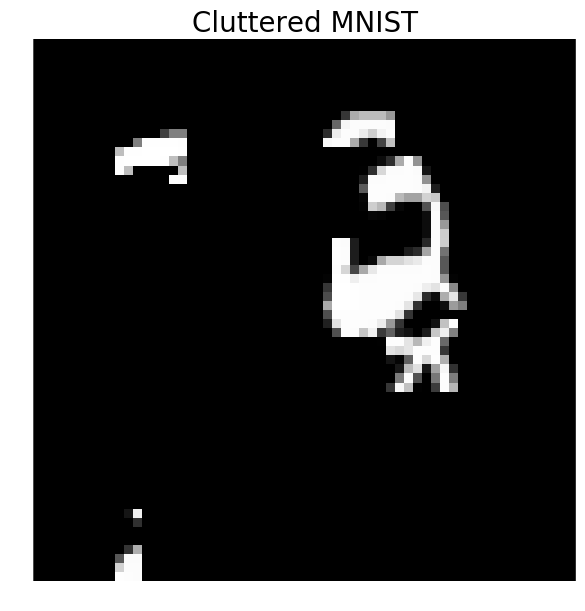

In [4]:
plt.figure(figsize=(7,7))
plt.imshow(data['X_train'][2].reshape(DIM, DIM), cmap='gray', interpolation='none')
plt.title('Cluttered MNIST', fontsize=20)
plt.axis('off')
plt.show()

# Building the model
We use a model where the localization network is a two layer convolution network which operates directly on the image input. The output from the localization network is a 6 dimensional vector specifying the parameters in the affine transformation. 

The localization feeds into the transformer layer which applies the transformation to the image input. In our setup the transformer layer downsamples the input by a factor 3. 

Finally a 2 layer convolution layer and 2 fully connected layers calculates the output probabilities. 

**The model**


    Input -> localization_network -> TransformerLayer -> output_network -> predictions
       |                                |
       >--------------------------------^

In [5]:
def build_model(input_width, input_height, output_dim, mins, maxs, ranges,
                batch_size=BATCH_SIZE, withdisc=True):
    ini = lasagne.init.HeUniform()
    l_in = lasagne.layers.InputLayer(shape=(None, 1, input_width, input_height),)

    # Localization network
    b = np.zeros((2, 3), dtype=theano.config.floatX)
    b[0, 0] = 1
    b[1, 1] = 1
    b = b.flatten()
    loc_l1 = pool(l_in, pool_size=(2, 2))
    loc_l2 = conv(
        loc_l1, num_filters=20, filter_size=(5, 5), W=ini)
    loc_l3 = pool(loc_l2, pool_size=(2, 2))
    loc_l4 = conv(loc_l3, num_filters=20, filter_size=(5, 5), W=ini)
    loc_l5 = lasagne.layers.DenseLayer(
        loc_l4, num_units=50, W=lasagne.init.HeUniform('relu'))
    loc_out = lasagne.layers.DenseLayer(
        loc_l5, num_units=6, b=b, W=lasagne.init.Constant(0.0), 
        nonlinearity=lasagne.nonlinearities.identity, name='param_regressor')
    
    if withdisc:
        l_dis = DiscreteLayer(loc_out, mins, maxs, ranges, name='disclayer')
        print("Using Discret. Layer")
    else:
        l_dis = loc_out
        Print("No Disc. Layer")
    
    # Transformer network
    l_trans1 = lasagne.layers.TransformerLayer(l_in, l_dis, downsample_factor=3.0)
    print "Transformer network output shape: ", l_trans1.output_shape
    
    # Classification network
    class_l1 = conv(
        l_trans1,
        num_filters=32,
        filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    )
    class_l2 = pool(class_l1, pool_size=(2, 2))
    class_l3 = conv(
        class_l2,
        num_filters=32,
        filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    )
    class_l4 = pool(class_l3, pool_size=(2, 2))
    class_l5 = lasagne.layers.DenseLayer(
        class_l4,
        num_units=256,
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    )

    l_out = lasagne.layers.DenseLayer(
        class_l5,
        num_units=output_dim,
        nonlinearity=lasagne.nonlinearities.softmax,
        W=ini,
    )

    return l_out, l_trans1

model, l_transform = build_model(DIM, DIM, NUM_CLASSES, MINS, MAXS, RANGES, withdisc=DISC)
model_params = lasagne.layers.get_all_params(model, trainable=True)

Using Discret. Layer
Transformer network output shape:  (None, 1, 20, 20)


In [6]:
X = T.tensor4(dtype=theano.config.floatX)
y = T.ivector()

## Layer History
l_disc = next(l for l in lasagne.layers.get_all_layers(model) if l.name is 'disclayer')
l_paramreg = next(l for l in lasagne.layers.get_all_layers(model) if l.name is 'param_regressor')

l_disc_output, l_paramreg_output = lasagne.layers.get_output([l_disc, l_paramreg], X, deterministic=False)
## Layer History

# training output
output_train = lasagne.layers.get_output(model, X, deterministic=False)

# evaluation output. Also includes output of transform for plotting
output_eval, transform_eval = lasagne.layers.get_output([model, l_transform], X, deterministic=True)

sh_lr = theano.shared(lasagne.utils.floatX(LEARNING_RATE))
cost = T.mean(T.nnet.categorical_crossentropy(output_train, y))
updates = lasagne.updates.adam(cost, model_params, learning_rate=sh_lr)

train = theano.function([X, y], [cost, output_train, l_disc_output, l_paramreg_output], updates=updates)
eval = theano.function([X], [output_eval, transform_eval])

In [7]:
def train_epoch(X, y):
    # History Keeping
    param_output = []
    disc_output = []
    # History
    num_samples = X.shape[0]
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))
    costs = []
    correct = 0
    for i in range(num_batches):
        idx = range(i*BATCH_SIZE, np.minimum((i+1)*BATCH_SIZE, num_samples))
        X_batch = X[idx]
        y_batch = y[idx]
        cost_batch, output_train, l_disc_output, l_paramreg_output = train(X_batch, y_batch)
        param_output = np.append(param_output, l_paramreg_output)
        disc_output = np.append(disc_output, l_disc_output)
        costs += [cost_batch]
        preds = np.argmax(output_train, axis=-1)
        correct += np.sum(y_batch == preds)
        
    return np.mean(costs), correct / float(num_samples), param_output, disc_output


def eval_epoch(X, y):
    output_eval, transform_eval = eval(X)
    preds = np.argmax(output_eval, axis=-1)
    acc = np.mean(preds == y)
    return acc, transform_eval

# Training

In [8]:
print data['X_train'][0:3].shape

(3, 1, 60, 60)


In [9]:
theano.config.exception_verbosity = 'high'
valid_accs, train_accs, test_accs = [], [], []
param_outputs, disc_outputs = [], []
try:
    for n in range(NUM_EPOCHS):
        start_time = time.time()
        train_cost, train_acc, param_output, disc_output = train_epoch(data['X_train'], data['y_train'])
        valid_acc, valid_trainsform = eval_epoch(data['X_valid'], data['y_valid'])
        test_acc, test_transform = eval_epoch(data['X_test'], data['y_test'])
        valid_accs += [valid_acc]
        test_accs += [test_acc]
        train_accs += [train_acc]
        #import pdb; pdb.set_trace()
        param_outputs = np.append(param_outputs, param_output)
        disc_outputs = np.append(disc_outputs, disc_output)
        
        if (n+1) % 20 == 0:
            new_lr = sh_lr.get_value() * 0.7
            print "New LR:", new_lr
            sh_lr.set_value(lasagne.utils.floatX(new_lr))

        print "Epoch {0}: Train cost {1}, Train acc {2}, val acc {3}, test acc {4}, took {5:.3} sec.".format(
                n, train_cost, train_acc, valid_acc, test_acc, time.time() - start_time)
except KeyboardInterrupt:
    pass

IndexError: tuple index out of range
Apply node that caused the error: DiscOP{mins=(0.3, -0.3, -0.8, 0.5, -0.7), maxs=(1.1, 0.1, 1.1, 0.4, 1.1, 1.5), ranges=(50, 50, 50, 50, 50, 50)}(HostFromGpu.0)
Toposort index: 151
Inputs types: [TensorType(float32, matrix)]
Inputs shapes: [(256, 6)]
Inputs strides: [(24, 4)]
Inputs values: ['not shown']
Inputs type_num: [11]
Outputs clients: [[Reshape{2}(DiscOP{mins=(0.3, -0.3, -0.8, 0.5, -0.7), maxs=(1.1, 0.1, 1.1, 0.4, 1.1, 1.5), ranges=(50, 50, 50, 50, 50, 50)}.0, MakeVector{dtype='int64'}.0), Shape_i{0}(DiscOP{mins=(0.3, -0.3, -0.8, 0.5, -0.7), maxs=(1.1, 0.1, 1.1, 0.4, 1.1, 1.5), ranges=(50, 50, 50, 50, 50, 50)}.0), Shape_i{1}(DiscOP{mins=(0.3, -0.3, -0.8, 0.5, -0.7), maxs=(1.1, 0.1, 1.1, 0.4, 1.1, 1.5), ranges=(50, 50, 50, 50, 50, 50)}.0), 'output']]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/home/ilker/anaconda2/envs/theano/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ilker/anaconda2/envs/theano/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ilker/anaconda2/envs/theano/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ilker/anaconda2/envs/theano/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ilker/anaconda2/envs/theano/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-a3cf72fa4d3e>", line 8, in <module>
    l_disc_output, l_paramreg_output = lasagne.layers.get_output([l_disc, l_paramreg], X, deterministic=False)
  File "/home/ilker/anaconda2/envs/theano/lib/python2.7/site-packages/lasagne/layers/helper.py", line 191, in get_output
    all_outputs[layer] = layer.get_output_for(layer_inputs, **kwargs)
  File "DiscreteLayer.py", line 13, in get_output_for
    return self.op(theta)

Debugprint of the apply node: 
DiscOP{mins=(0.3, -0.3, -0.8, 0.5, -0.7), maxs=(1.1, 0.1, 1.1, 0.4, 1.1, 1.5), ranges=(50, 50, 50, 50, 50, 50)} [id A] <TensorType(float32, matrix)> ''   
 |HostFromGpu [id B] <TensorType(float32, matrix)> ''   
   |GpuElemwise{Add}[(0, 0)] [id C] <CudaNdarrayType(float32, matrix)> ''   
     |GpuDot22 [id D] <CudaNdarrayType(float32, matrix)> ''   
     | |GpuElemwise{Composite{(i0 * (i1 + Abs(i1)))},no_inplace} [id E] <CudaNdarrayType(float32, matrix)> ''   
     | | |CudaNdarrayConstant{[[ 0.5]]} [id F] <CudaNdarrayType(float32, (True, True))>
     | | |GpuElemwise{Add}[(0, 0)] [id G] <CudaNdarrayType(float32, matrix)> ''   
     | |   |GpuDot22 [id H] <CudaNdarrayType(float32, matrix)> ''   
     | |   | |GpuReshape{2} [id I] <CudaNdarrayType(float32, matrix)> ''   
     | |   | | |GpuElemwise{Composite{(i0 * (i1 + Abs(i1)))},no_inplace} [id J] <CudaNdarrayType(float32, 4D)> ''   
     | |   | | | |CudaNdarrayConstant{[[[[ 0.5]]]]} [id K] <CudaNdarrayType(float32, (True, True, True, True))>
     | |   | | | |GpuElemwise{Add}[(0, 0)] [id L] <CudaNdarrayType(float32, 4D)> ''   
     | |   | | |   |GpuDnnConv{algo='small', inplace=True} [id M] <CudaNdarrayType(float32, 4D)> ''   
     | |   | | |   | |GpuContiguous [id N] <CudaNdarrayType(float32, 4D)> ''   
     | |   | | |   | | |GpuDnnPool{mode='max'} [id O] <CudaNdarrayType(float32, 4D)> ''   
     | |   | | |   | |   |GpuContiguous [id P] <CudaNdarrayType(float32, 4D)> ''   
     | |   | | |   | |   | |GpuElemwise{Composite{(i0 * (i1 + Abs(i1)))},no_inplace} [id Q] <CudaNdarrayType(float32, 4D)> ''   
     | |   | | |   | |   |   |CudaNdarrayConstant{[[[[ 0.5]]]]} [id K] <CudaNdarrayType(float32, (True, True, True, True))>
     | |   | | |   | |   |   |GpuElemwise{Add}[(0, 0)] [id R] <CudaNdarrayType(float32, 4D)> ''   
     | |   | | |   | |   |     |GpuDnnConv{algo='small', inplace=True} [id S] <CudaNdarrayType(float32, 4D)> ''   
     | |   | | |   | |   |     | |GpuContiguous [id T] <CudaNdarrayType(float32, 4D)> ''   
     | |   | | |   | |   |     | | |GpuDnnPool{mode='max'} [id U] <CudaNdarrayType(float32, 4D)> ''   
     | |   | | |   | |   |     | |   |GpuContiguous [id V] <CudaNdarrayType(float32, 4D)> ''   
     | |   | | |   | |   |     | |   | |GpuFromHost [id W] <CudaNdarrayType(float32, 4D)> ''   
     | |   | | |   | |   |     | |   |   |<TensorType(float32, 4D)> [id X] <TensorType(float32, 4D)>
     | |   | | |   | |   |     | |   |TensorConstant{(2,) of 2} [id Y] <TensorType(int64, vector)>
     | |   | | |   | |   |     | |   |TensorConstant{(2,) of 2} [id Y] <TensorType(int64, vector)>
     | |   | | |   | |   |     | |   |TensorConstant{(2,) of 0} [id Z] <TensorType(int64, vector)>
     | |   | | |   | |   |     | |GpuContiguous [id BA] <CudaNdarrayType(float32, (False, True, False, False))> ''   
     | |   | | |   | |   |     | | |W [id BB] <CudaNdarrayType(float32, (False, True, False, False))>
     | |   | | |   | |   |     | |GpuAllocEmpty [id BC] <CudaNdarrayType(float32, 4D)> ''   
     | |   | | |   | |   |     | | |Shape_i{0} [id BD] <TensorType(int64, scalar)> ''   
     | |   | | |   | |   |     | | | |<TensorType(float32, 4D)> [id X] <TensorType(float32, 4D)>
     | |   | | |   | |   |     | | |Shape_i{0} [id BE] <TensorType(int64, scalar)> ''   
     | |   | | |   | |   |     | | | |W [id BB] <CudaNdarrayType(float32, (False, True, False, False))>
     | |   | | |   | |   |     | | |Elemwise{Composite{((i0 - (((i1 - i2) * i3) + i2)) + i2)}}[(0, 0)] [id BF] <TensorType(int64, scalar)> ''   
     | |   | | |   | |   |     | | | |Elemwise{int_div,no_inplace} [id BG] <TensorType(int64, scalar)> ''   
     | |   | | |   | |   |     | | | | |Shape_i{2} [id BH] <TensorType(int64, scalar)> ''   
     | |   | | |   | |   |     | | | | | |<TensorType(float32, 4D)> [id X] <TensorType(float32, 4D)>
     | |   | | |   | |   |     | | | | |TensorConstant{2} [id BI] <TensorType(int8, scalar)>
     | |   | | |   | |   |     | | | |Shape_i{2} [id BJ] <TensorType(int64, scalar)> ''   
     | |   | | |   | |   |     | | | | |W [id BB] <CudaNdarrayType(float32, (False, True, False, False))>
     | |   | | |   | |   |     | | | |TensorConstant{1} [id BK] <TensorType(int8, scalar)>
     | |   | | |   | |   |     | | | |TensorConstant{1} [id BL] <TensorType(int64, scalar)>
     | |   | | |   | |   |     | | |Elemwise{Composite{((i0 - (((i1 - i2) * i3) + i2)) + i2)}}[(0, 0)] [id BM] <TensorType(int64, scalar)> ''   
     | |   | | |   | |   |     | |   |Elemwise{int_div,no_inplace} [id BN] <TensorType(int64, scalar)> ''   
     | |   | | |   | |   |     | |   | |Shape_i{3} [id BO] <TensorType(int64, scalar)> ''   
     | |   | | |   | |   |     | |   | | |<TensorType(float32, 4D)> [id X] <TensorType(float32, 4D)>
     | |   | | |   | |   |     | |   | |TensorConstant{2} [id BI] <TensorType(int8, scalar)>
     | |   | | |   | |   |     | |   |Shape_i{3} [id BP] <TensorType(int64, scalar)> ''   
     | |   | | |   | |   |     | |   | |W [id BB] <CudaNdarrayType(float32, (False, True, False, False))>
     | |   | | |   | |   |     | |   |TensorConstant{1} [id BK] <TensorType(int8, scalar)>
     | |   | | |   | |   |     | |   |TensorConstant{1} [id BL] <TensorType(int64, scalar)>
     | |   | | |   | |   |     | |GpuDnnConvDesc{border_mode='valid', subsample=(1, 1), conv_mode='conv', precision='float32'} [id BQ] <CDataType{cudnnConvolutionDescriptor_t}> ''   
     | |   | | |   | |   |     | | |MakeVector{dtype='int64'} [id BR] <TensorType(int64, vector)> ''   
     | |   | | |   | |   |     | | | |Shape_i{0} [id BD] <TensorType(int64, scalar)> ''   
     | |   | | |   | |   |     | | | |Shape_i{1} [id BS] <TensorType(int64, scalar)> ''   
     | |   | | |   | |   |     | | | | |<TensorType(float32, 4D)> [id X] <TensorType(float32, 4D)>
     | |   | | |   | |   |     | | | |Elemwise{int_div,no_inplace} [id BG] <TensorType(int64, scalar)> ''   
     | |   | | |   | |   |     | | | |Elemwise{int_div,no_inplace} [id BN] <TensorType(int64, scalar)> ''   
     | |   | | |   | |   |     | | |MakeVector{dtype='int64'} [id BT] <TensorType(int64, vector)> ''   
     | |   | | |   | |   |     | |   |Shape_i{0} [id BE] <TensorType(int64, scalar)> ''   
     | |   | | |   | |   |     | |   |TensorConstant{1} [id BL] <TensorType(int64, scalar)>
     | |   | | |   | |   |     | |   |Shape_i{2} [id BJ] <TensorType(int64, scalar)> ''   
     | |   | | |   | |   |     | |   |Shape_i{3} [id BP] <TensorType(int64, scalar)> ''   
     | |   | | |   | |   |     | |Constant{1.0} [id BU] <float32>
     | |   | | |   | |   |     | |Constant{0.0} [id BV] <float32>
     | |   | | |   | |   |     |GpuDimShuffle{x,0,x,x} [id BW] <CudaNdarrayType(float32, (True, False, True, True))> ''   
     | |   | | |   | |   |       |b [id BX] <CudaNdarrayType(float32, vector)>
     | |   | | |   | |   |TensorConstant{(2,) of 2} [id Y] <TensorType(int64, vector)>
     | |   | | |   | |   |TensorConstant{(2,) of 2} [id Y] <TensorType(int64, vector)>
     | |   | | |   | |   |TensorConstant{(2,) of 0} [id Z] <TensorType(int64, vector)>
     | |   | | |   | |GpuContiguous [id BY] <CudaNdarrayType(float32, 4D)> ''   
     | |   | | |   | | |W [id BZ] <CudaNdarrayType(float32, 4D)>
     | |   | | |   | |GpuAllocEmpty [id CA] <CudaNdarrayType(float32, 4D)> ''   
     | |   | | |   | | |Shape_i{0} [id BD] <TensorType(int64, scalar)> ''   
     | |   | | |   | | |Shape_i{0} [id CB] <TensorType(int64, scalar)> ''   
     | |   | | |   | | | |W [id BZ] <CudaNdarrayType(float32, 4D)>
     | |   | | |   | | |Elemwise{Composite{((i0 - (((i1 - i2) * i3) + i2)) + i2)}} [id CC] <TensorType(int64, scalar)> ''   
     | |   | | |   | | | |TensorConstant{13} [id CD] <TensorType(int64, scalar)>
     | |   | | |   | | | |Shape_i{2} [id CE] <TensorType(int64, scalar)> ''   
     | |   | | |   | | | | |W [id BZ] <CudaNdarrayType(float32, 4D)>
     | |   | | |   | | | |TensorConstant{1} [id BK] <TensorType(int8, scalar)>
     | |   | | |   | | | |TensorConstant{1} [id BL] <TensorType(int64, scalar)>
     | |   | | |   | | |Elemwise{Composite{((i0 - (((i1 - i2) * i3) + i2)) + i2)}} [id CF] <TensorType(int64, scalar)> ''   
     | |   | | |   | |   |TensorConstant{13} [id CD] <TensorType(int64, scalar)>
     | |   | | |   | |   |Shape_i{3} [id CG] <TensorType(int64, scalar)> ''   
     | |   | | |   | |   | |W [id BZ] <CudaNdarrayType(float32, 4D)>
     | |   | | |   | |   |TensorConstant{1} [id BK] <TensorType(int8, scalar)>
     | |   | | |   | |   |TensorConstant{1} [id BL] <TensorType(int64, scalar)>
     | |   | | |   | |GpuDnnConvDesc{border_mode='valid', subsample=(1, 1), conv_mode='conv', precision='float32'} [id CH] <CDataType{cudnnConvolutionDescriptor_t}> ''   
     | |   | | |   | | |MakeVector{dtype='int64'} [id CI] <TensorType(int64, vector)> ''   
     | |   | | |   | | | |Shape_i{0} [id BD] <TensorType(int64, scalar)> ''   
     | |   | | |   | | | |TensorConstant{20} [id CJ] <TensorType(int64, scalar)>
     | |   | | |   | | | |TensorConstant{13} [id CD] <TensorType(int64, scalar)>
     | |   | | |   | | | |TensorConstant{13} [id CD] <TensorType(int64, scalar)>
     | |   | | |   | | |MakeVector{dtype='int64'} [id CK] <TensorType(int64, vector)> ''   
     | |   | | |   | |   |Shape_i{0} [id CB] <TensorType(int64, scalar)> ''   
     | |   | | |   | |   |Shape_i{1} [id CL] <TensorType(int64, scalar)> ''   
     | |   | | |   | |   | |W [id BZ] <CudaNdarrayType(float32, 4D)>
     | |   | | |   | |   |Shape_i{2} [id CE] <TensorType(int64, scalar)> ''   
     | |   | | |   | |   |Shape_i{3} [id CG] <TensorType(int64, scalar)> ''   
     | |   | | |   | |Constant{1.0} [id BU] <float32>
     | |   | | |   | |Constant{0.0} [id BV] <float32>
     | |   | | |   |GpuDimShuffle{x,0,x,x} [id CM] <CudaNdarrayType(float32, (True, False, True, True))> ''   
     | |   | | |     |b [id CN] <CudaNdarrayType(float32, vector)>
     | |   | | |MakeVector{dtype='int64'} [id CO] <TensorType(int64, vector)> ''   
     | |   | |   |Shape_i{0} [id BD] <TensorType(int64, scalar)> ''   
     | |   | |   |TensorConstant{-1} [id CP] <TensorType(int64, scalar)>
     | |   | |W [id CQ] <CudaNdarrayType(float32, matrix)>
     | |   |GpuDimShuffle{x,0} [id CR] <CudaNdarrayType(float32, row)> ''   
     | |     |b [id CS] <CudaNdarrayType(float32, vector)>
     | |param_regressor.W [id CT] <CudaNdarrayType(float32, matrix)>
     |GpuDimShuffle{x,0} [id CU] <CudaNdarrayType(float32, row)> ''   
       |param_regressor.b [id CV] <CudaNdarrayType(float32, vector)>

Storage map footprint:
 - GpuContiguous.0, Shape: (256, 20, 26, 26), ElemSize: 4 Byte(s), TotalSize: 13844480 Byte(s)
 - GpuElemwise{Add}[(0, 0)].0, Shape: (256, 20, 26, 26), ElemSize: 4 Byte(s), TotalSize: 13844480 Byte(s)
 - <TensorType(float32, 4D)>, Input, Shape: (256, 1, 60, 60), ElemSize: 4 Byte(s), TotalSize: 3686400 Byte(s)
 - GpuFromHost.0, Shape: (256, 1, 60, 60), ElemSize: 4 Byte(s), TotalSize: 3686400 Byte(s)
 - GpuContiguous.0, Shape: (256, 20, 13, 13), ElemSize: 4 Byte(s), TotalSize: 3461120 Byte(s)
 - GpuReshape{2}.0, Shape: (256, 1620), ElemSize: 4 Byte(s), TotalSize: 1658880 Byte(s)
 - GpuElemwise{Add}[(0, 0)].0, Shape: (256, 20, 9, 9), ElemSize: 4 Byte(s), TotalSize: 1658880 Byte(s)
 - GpuContiguous.0, Shape: (256, 1, 30, 30), ElemSize: 4 Byte(s), TotalSize: 921600 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (1620, 50), ElemSize: 4 Byte(s), TotalSize: 324000 Byte(s)
 - W, Shared Input, Shape: (1620, 50), ElemSize: 4 Byte(s), TotalSize: 324000 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (1620, 50), ElemSize: 4 Byte(s), TotalSize: 324000 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (288, 256), ElemSize: 4 Byte(s), TotalSize: 294912 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (288, 256), ElemSize: 4 Byte(s), TotalSize: 294912 Byte(s)
 - W, Shared Input, Shape: (288, 256), ElemSize: 4 Byte(s), TotalSize: 294912 Byte(s)
 - GpuElemwise{Add}[(0, 0)].0, Shape: (256, 50), ElemSize: 4 Byte(s), TotalSize: 51200 Byte(s)
 - GpuElemwise{Composite{(i0 * (i1 + Abs(i1)))},no_inplace}.0, Shape: (256, 50), ElemSize: 4 Byte(s), TotalSize: 51200 Byte(s)
 - GpuContiguous.0, Shape: (20, 20, 5, 5), ElemSize: 4 Byte(s), TotalSize: 40000 Byte(s)
 - W, Shared Input, Shape: (20, 20, 5, 5), ElemSize: 4 Byte(s), TotalSize: 40000 Byte(s)
 - <CudaNdarrayType(float32, 4D)>, Shared Input, Shape: (20, 20, 5, 5), ElemSize: 4 Byte(s), TotalSize: 40000 Byte(s)
 - <CudaNdarrayType(float32, 4D)>, Shared Input, Shape: (20, 20, 5, 5), ElemSize: 4 Byte(s), TotalSize: 40000 Byte(s)
 - <CudaNdarrayType(float32, 4D)>, Shared Input, Shape: (32, 32, 3, 3), ElemSize: 4 Byte(s), TotalSize: 36864 Byte(s)
 - W, Shared Input, Shape: (32, 32, 3, 3), ElemSize: 4 Byte(s), TotalSize: 36864 Byte(s)
 - <CudaNdarrayType(float32, 4D)>, Shared Input, Shape: (32, 32, 3, 3), ElemSize: 4 Byte(s), TotalSize: 36864 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (256, 10), ElemSize: 4 Byte(s), TotalSize: 10240 Byte(s)
 - W, Shared Input, Shape: (256, 10), ElemSize: 4 Byte(s), TotalSize: 10240 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (256, 10), ElemSize: 4 Byte(s), TotalSize: 10240 Byte(s)
 - HostFromGpu.0, Shape: (256, 6), ElemSize: 4 Byte(s), TotalSize: 6144 Byte(s)
 - <CudaNdarrayType(float32, (False, True, False, False))>, Shared Input, Shape: (20, 1, 5, 5), ElemSize: 4 Byte(s), TotalSize: 2000 Byte(s)
 - <CudaNdarrayType(float32, (False, True, False, False))>, Shared Input, Shape: (20, 1, 5, 5), ElemSize: 4 Byte(s), TotalSize: 2000 Byte(s)
 - W, Shared Input, Shape: (20, 1, 5, 5), ElemSize: 4 Byte(s), TotalSize: 2000 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (50, 6), ElemSize: 4 Byte(s), TotalSize: 1200 Byte(s)
 - param_regressor.W, Shared Input, Shape: (50, 6), ElemSize: 4 Byte(s), TotalSize: 1200 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (50, 6), ElemSize: 4 Byte(s), TotalSize: 1200 Byte(s)
 - W, Shared Input, Shape: (32, 1, 3, 3), ElemSize: 4 Byte(s), TotalSize: 1152 Byte(s)
 - <CudaNdarrayType(float32, (False, True, False, False))>, Shared Input, Shape: (32, 1, 3, 3), ElemSize: 4 Byte(s), TotalSize: 1152 Byte(s)
 - <CudaNdarrayType(float32, (False, True, False, False))>, Shared Input, Shape: (32, 1, 3, 3), ElemSize: 4 Byte(s), TotalSize: 1152 Byte(s)
 - b, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - <TensorType(int32, vector)>, Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - b, Shared Input, Shape: (50,), ElemSize: 4 Byte(s), TotalSize: 200 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (50,), ElemSize: 4 Byte(s), TotalSize: 200 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (50,), ElemSize: 4 Byte(s), TotalSize: 200 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (32,), ElemSize: 4 Byte(s), TotalSize: 128 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (32,), ElemSize: 4 Byte(s), TotalSize: 128 Byte(s)
 - b, Shared Input, Shape: (32,), ElemSize: 4 Byte(s), TotalSize: 128 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (32,), ElemSize: 4 Byte(s), TotalSize: 128 Byte(s)
 - b, Shared Input, Shape: (32,), ElemSize: 4 Byte(s), TotalSize: 128 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (32,), ElemSize: 4 Byte(s), TotalSize: 128 Byte(s)
 - b, Shared Input, Shape: (20,), ElemSize: 4 Byte(s), TotalSize: 80 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (20,), ElemSize: 4 Byte(s), TotalSize: 80 Byte(s)
 - b, Shared Input, Shape: (20,), ElemSize: 4 Byte(s), TotalSize: 80 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (20,), ElemSize: 4 Byte(s), TotalSize: 80 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (20,), ElemSize: 4 Byte(s), TotalSize: 80 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (20,), ElemSize: 4 Byte(s), TotalSize: 80 Byte(s)
 - b, Shared Input, Shape: (10,), ElemSize: 4 Byte(s), TotalSize: 40 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (10,), ElemSize: 4 Byte(s), TotalSize: 40 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (10,), ElemSize: 4 Byte(s), TotalSize: 40 Byte(s)
 - TensorConstant{(4,) of 1}, Shape: (4,), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (4,), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (4,), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - param_regressor.b, Shared Input, Shape: (6,), ElemSize: 4 Byte(s), TotalSize: 24 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (6,), ElemSize: 4 Byte(s), TotalSize: 24 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (6,), ElemSize: 4 Byte(s), TotalSize: 24 Byte(s)
 - TensorConstant{(2,) of 2}, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - TensorConstant{[ 1 -1]}, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - TensorConstant{(2,) of 0}, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - TensorConstant{6}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{1}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{1}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{2}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{3}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{2}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{0}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{-6}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{2}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{0.333333333333}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{13}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{3}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{3}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{32}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1,) of -1}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{-1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{4}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{9}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{3}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{20}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{-3}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1,) of 2.0}, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[[[ 0.10000002]]]]}, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[  9.99999994e-09]}, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[ 0.00099999]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[ 0.99900001]}, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[[[ 0.5]]]]}, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[ 0.00099999]}, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[[[ 0.00099999]]]]}, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - TensorConstant{(1,) of 0.5}, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - <CudaNdarrayType(float32, scalar)>, Shared Input, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{0.100000023842}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - <CudaNdarrayType(float32, scalar)>, Shared Input, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{0.0}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - CudaNdarrayConstant{[[[[ 0.99900001]]]]}, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[[[ 0.89999998]]]]}, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Constant{1.0}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - Constant{0.0}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - CudaNdarrayConstant{[[  9.99999994e-09]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - TensorConstant{1.0}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - CudaNdarrayConstant{[[ 0.99900001]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[ 0.10000002]}, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - TensorConstant{0.5}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - CudaNdarrayConstant{0.899999976158}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{(1,) of 1.0}, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[ 0.89999998]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[ 0.5]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - TensorConstant{(1,) of -1.0}, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[ 0.89999998]}, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[[[  9.99999994e-09]]]]}, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{0.999000012875}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - CudaNdarrayConstant{[ 0.5]}, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[[ 0.]]]}, Shape: (1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{1.0}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{(1, 1) of 1.0}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Constant{0.1}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{0}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{(1,) of -1}, Shape: (1,), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - TensorConstant{1}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{2}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{(1,) of 1}, Shape: (1,), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - TensorConstant{-1}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 TotalSize: 45008538.0 Byte(s) 0.042 GB
 TotalSize inputs: 5824002.0 Byte(s) 0.005 GB



# Plot results

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(1-np.array(train_accs), label='Training Error')
plt.plot(1-np.array(valid_accs), label='Validation Error')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=8)
plt.ylabel('Error', fontsize=8)
plt.show()

In [ ]:
# Reshape
dense_params = param_outputs.reshape((-1, 6))
disc_params = disc_outputs.reshape((-1, 6))
print dense_params.shape


plt.figure()
plt.plot(dense_params[::100, 0], 'o')
plt.grid(True)


plt.figure()
plt.plot(dense_params[::100, 1], 'o')
plt.grid(True)

plt.figure()
plt.plot(dense_params[::100, 2], 'o')
plt.grid(True)

plt.figure()
plt.plot(dense_params[::100, 3], 'o')
plt.grid(True)

plt.figure()
plt.plot(dense_params[::100, 4], 'o')
plt.grid(True)

plt.figure()
plt.plot(dense_params[::100, 5], 'o')
plt.grid(True)


plt.figure()
plt.plot(disc_params[::100, 1], 'o')
plt.grid(True)

plt.figure()
plt.plot(disc_params[::100, 3], 'o')
plt.grid(True)

"""
plt.figure()
plt.plot(disc_params[0, 199000:200000:10], '.')
plt.grid(True)

plt.figure()
plt.plot(dense_params[1, 0:300000:100], '.')

plt.figure()
plt.plot(disc_params[1, 0:300000:100], '.')
"""

In [ ]:

plt.figure(figsize=(7,14))
for i in range(3):
    plt.subplot(321+i*2)
    plt.imshow(data['X_test'][i].reshape(DIM, DIM), cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Original 60x60', fontsize=20)
    plt.axis('off')
    plt.subplot(322+i*2)
    plt.imshow(test_transform[i].reshape(DIM//3, DIM//3), cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Transformed 20x20', fontsize=20)
    plt.axis('off')
plt.tight_layout()




# References
[1] Jaderberg, Max, et al. "Spatial Transformer Networks." arXiv preprint arXiv:1506.02025 (2015).
